# Cognition and Computation 2023-2024 project
Fashion MNIST dataset

Oksana Abramova (2073541)

24.01.2024

Downloading scripts implementing a DBN in PyTorch and importing Python libraries needed for the project

In [ ]:
def get_dbn_library():
  files = ['DBN.py', 'RBM.py']
  repository_url = "https://raw.githubusercontent.com/flavio2018/Deep-Belief-Network-pytorch/master/"
  for file in files:
    ! wget -O {file} {repository_url}{file}

In [ ]:
%%capture
get_dbn_library()

In [ ]:
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.cluster as cluster
import sklearn.preprocessing
import torch
import torchvision as tv
import tqdm
from sklearn.metrics import confusion_matrix
import seaborn as sns
from skimage.util import random_noise
import tensorflow as tf
from tensorflow import keras


from DBN import DBN

Choosing the kind of device used for computations (CPU or GPU)

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)

True
cuda


Downloading the Fashion MNIST dataset. Normalizing input values to be encoded between 0 and 1

This dataset contains 60 000 train and 10 000 test 28x28 grayscale images. The images are of fashion products from 10 categories, with 7000 images per category.

In [ ]:
%%capture
fsh_mnist_train = tv.datasets.FashionMNIST('data/', train = True, download=True)
fsh_mnist_test = tv.datasets.FashionMNIST('data/', train = False, download=True)

In [ ]:
fsh_mnist_train.data = (fsh_mnist_train.data.type(torch.FloatTensor) / 255)
fsh_mnist_test.data = (fsh_mnist_test.data.type(torch.FloatTensor) / 255)

fsh_mnist_train.data = fsh_mnist_train.data.to(device)
fsh_mnist_test.data = fsh_mnist_test.data.to(device)
fsh_mnist_train.targets = fsh_mnist_train.targets.to(device)
fsh_mnist_test.targets = fsh_mnist_test.targets.to(device)

print(fsh_mnist_train.data.shape) # checking the dimensionality
print(fsh_mnist_test.data.shape)
print(fsh_mnist_train.targets.shape)
print(fsh_mnist_test.targets.shape)

torch.Size([60000, 28, 28])
torch.Size([10000, 28, 28])
torch.Size([60000])
torch.Size([10000])


The image shows the category number: 9


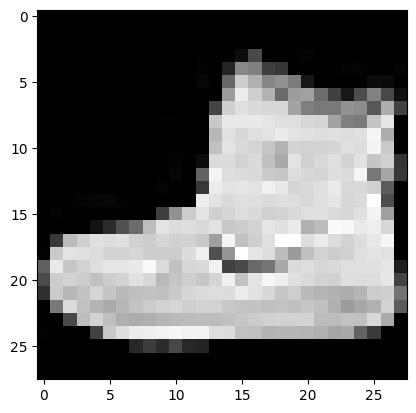

In [ ]:
# visualization of one training image
idx = 0
img = fsh_mnist_train.data[idx].cpu()
print('The image shows the category number: {}'.format(fsh_mnist_train.targets[idx]))
plt.imshow(img, cmap = 'gray')
plt.show()

# Deep Belief Network

- Hierarchical generative model made of a stack of Restricted Boltzmann Machines
- Learning is unsupervised
- Defined with the following parameters:

In [ ]:
dbn_fsh = DBN(visible_units = 28*28,
              hidden_units = [400, 600, 800],
              k = 1,
              learning_rate = 0.1,
              learning_rate_decay = False,
              initial_momentum = 0.5,
              final_momentum = 0.9,
              weight_decay = 0.0002,
              xavier_init = False,
              increase_to_cd_k = False,
              use_gpu = torch.cuda.is_available())

In [ ]:
# Training the network
num_epochs = 50
batch_size = 100

dbn_fsh.train_static(
    fsh_mnist_train.data,
    fsh_mnist_train.targets,
    num_epochs,
    batch_size
)

--------------------
Training RBM layer 1
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.4794     |0.0725       |305.0742   |7.6650     |
|20    |1.3696     |0.0696       |279.6291   |5.8768     |
|30    |1.3397     |0.0680       |272.1047   |6.2218     |
|40    |1.3241     |0.0671       |268.4032   |5.9472     |
|50    |1.3181     |0.0673       |267.5466   |6.2597     |
--------------------
Training RBM layer 2
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |1.0074     |0.0378       |154.4572   |3.0411     |
|20    |0.9377     |0.0337       |146.0153   |2.9913     |
|30    |0.9206     |0.0312       |143.2382   |2.8171     |
|40    |0.9117     |0.0314       |141.4155   |3.0010     |
|50    |0.9052     |0.0323       |140.5767   |2.7959     |
--------------------
Training RBM layer 3
|Epoch |avg_rec_err |std_rec_err  |mean_grad |std_grad  |
|10    |0.6246     |0.0214       |156.0255   |3.0014     |
|20    |0.5634     |0.0190       |147.3016   |3.134

# Visualization of receptive fields
Visualization of the learned weights will allow us to see which parts of the image trigger the unit assiciated with a specific weight vector.

To make a comparison between the visualizations we need to rescale weights for their values to be in the same range.

By applying a threshold we are making the plots less noisy.

Another important moment is that second and third hidden layers have a different dimensionality from the first one. In order to visualize them as images we are projecting each vector in a space of 28x28

In [ ]:
def get_weights(dbn, layer):
  return dbn.rbm_layers[layer].W.cpu().numpy()

def apply_threshold(weights, threshold=0):
  return weights * (abs(weights) > threshold)

def apply_min_max_scaler(learned_weights):
  original_shape = learned_weights.shape
  min_max_scaler = sklearn.preprocessing.MinMaxScaler()
  min_max_scaled_learned_weights = min_max_scaler.fit_transform(learned_weights.ravel().reshape(-1,1))
  min_max_scaled_learned_weights = min_max_scaled_learned_weights.reshape(original_shape)
  return min_max_scaled_learned_weights

def plot_layer_receptive_fields(weights):
  num_subplots = 100
  n_rows_cols = int(math.sqrt(num_subplots))
  fig, axes = plt.subplots(n_rows_cols, n_rows_cols, sharex=True, sharey=True, figsize=(10, 10))
  for i in range(num_subplots):
    row = i % n_rows_cols
    col = i // n_rows_cols
    axes[row, col].imshow(weights[i,:].reshape((28,28)), cmap=plt.cm.gray)  # here we select the weights we want to plot

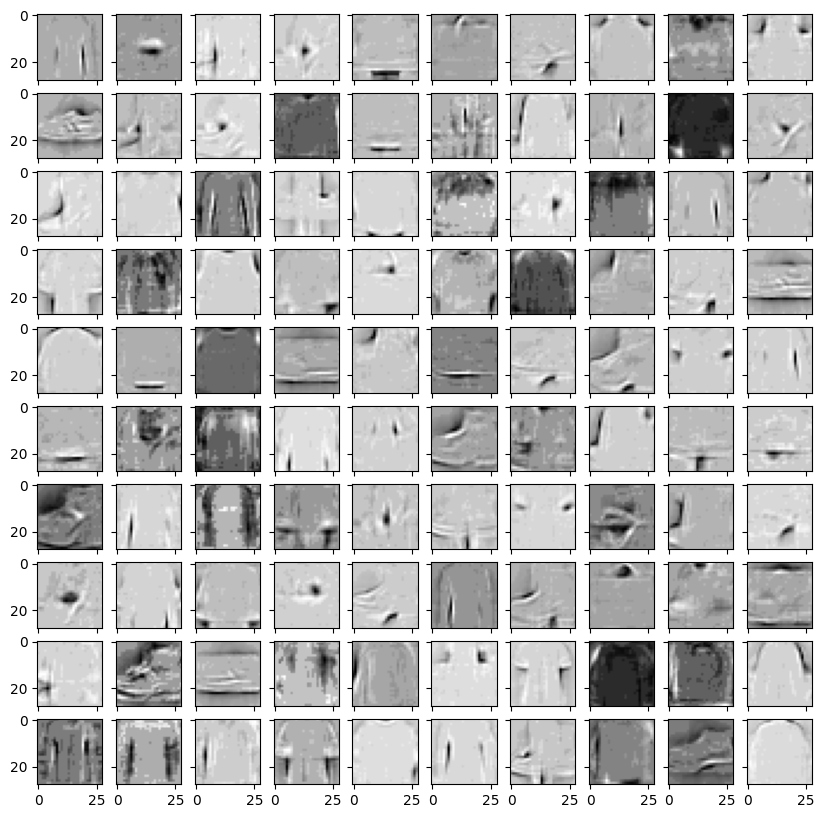

In [ ]:
w1 = get_weights(dbn_fsh, layer = 0)
w1 = apply_threshold(w1, 0.1)
w1 = apply_min_max_scaler(w1)

plot_layer_receptive_fields(w1.T)

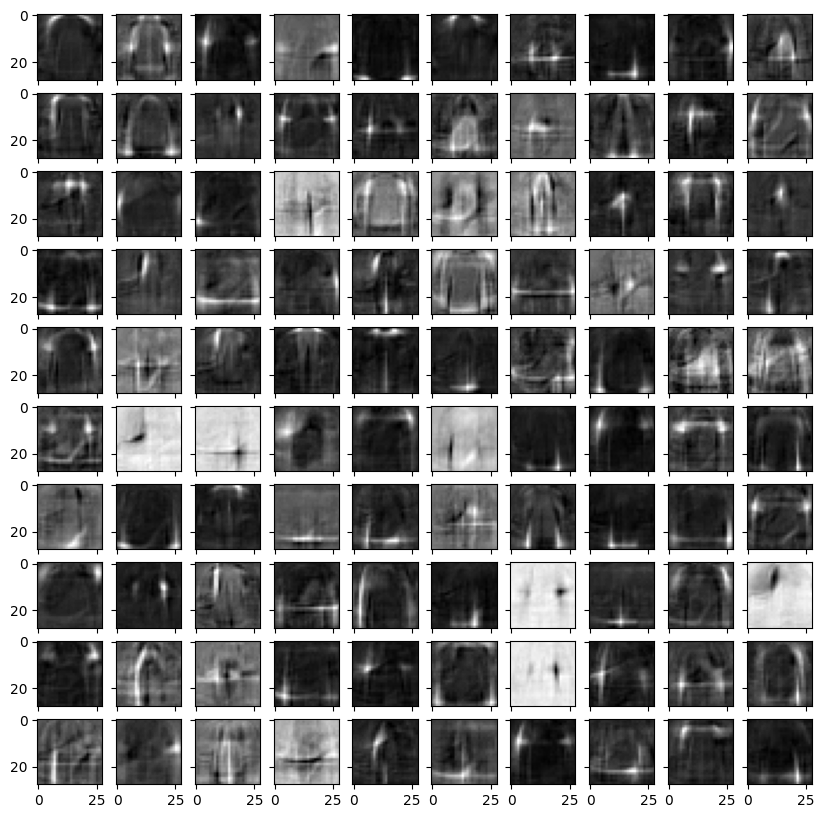

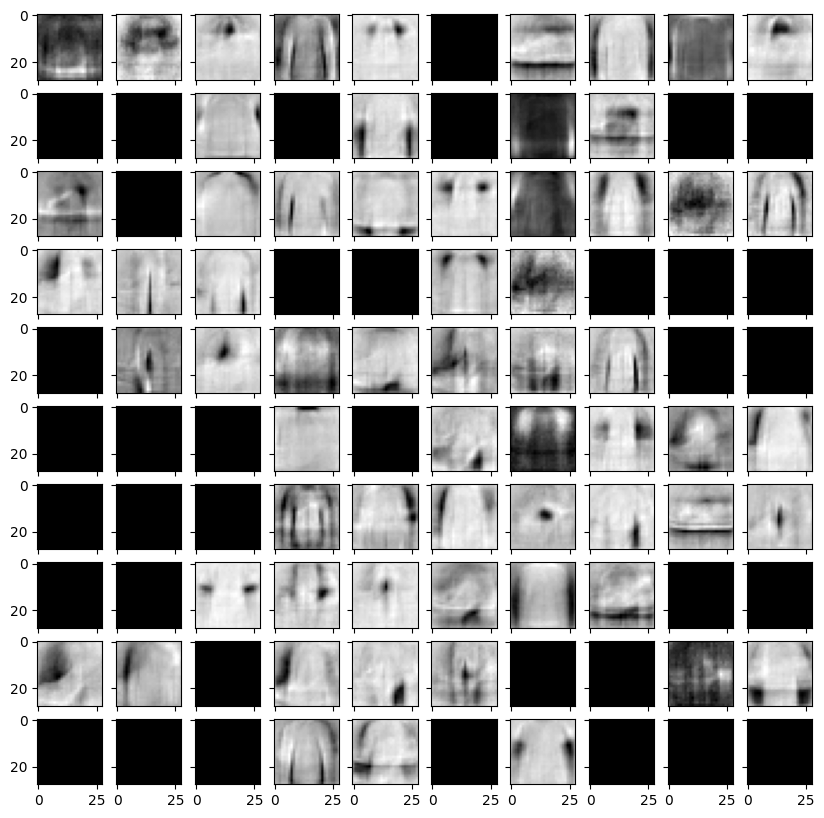

In [ ]:
w1 = get_weights(dbn_fsh, layer=0)
w2 = get_weights(dbn_fsh, layer=1)
w3 = get_weights(dbn_fsh, layer=2)

w1 = apply_threshold(w1, 0.1)
w2 = apply_threshold(w2, 0.1)
w3 = apply_threshold(w3, 0.1)

w_product_12 = (w1 @ w2)  # here we do the projection
w_product_23 = (w_product_12 @ w3)  # here we do the projection
w_product_23 = apply_threshold(w_product_23, 0.1)
w_product_23 = apply_min_max_scaler(w_product_23)

plot_layer_receptive_fields(w_product_12.T)
plot_layer_receptive_fields(w_product_23.T)

# Clustering
We can examine the properties of the learned representations by computing the centroid of the representations learned for each class. Then we see how close they are to each other with the standard hirarchical clustering algorithm.

We need to compute the hidden representation using the weights of each RBM contained in the DBN.

In [ ]:
def get_kth_layer_repr(input, k, device):
  flattened_input = input.view((input.shape[0], -1)).type(torch.FloatTensor).to(device)
  hidden_repr, __ = dbn_fsh.rbm_layers[k].to_hidden(flattened_input)
  return hidden_repr

In [ ]:
hidden_repr_1 = get_kth_layer_repr(fsh_mnist_train.data, 0, device)
hidden_repr_2 = get_kth_layer_repr(hidden_repr_1, 1, device)
hidden_repr_3 = get_kth_layer_repr(hidden_repr_2, 2, device)
print(hidden_repr_1.shape)
print(hidden_repr_2.shape)
print(hidden_repr_3.shape)

torch.Size([60000, 400])
torch.Size([60000, 600])
torch.Size([60000, 800])


In [ ]:
# Filtering by class
def get_mask(label):
  labels = fsh_mnist_train.targets.cpu().numpy()
  return labels == label

# Computing the mean of the representations
def get_label_to_mean_hidd_repr(hidden_repr):
  hidden_repr_np = hidden_repr.cpu().numpy()
  return {
      label: hidden_repr_np[get_mask(label)].mean(axis=0)
      for label in range(10)
  }

# Building a matrix with all the centroids
def get_hidden_reprs_matrix(hidden_repr):
  label_to_mean_hidd_repr = get_label_to_mean_hidd_repr(hidden_repr)
  return np.concatenate(
      [np.expand_dims(label_to_mean_hidd_repr[label], axis=0)
      for label in range(10)]
  )

In [ ]:
mean_hidd_repr_matrix_2 = get_hidden_reprs_matrix(hidden_repr_2)
mean_hidd_repr_matrix_3 = get_hidden_reprs_matrix(hidden_repr_3)

Next we apply the clustering and plot a dendrogram for the second and third hidden layers

In [ ]:
def plot_dendrogram(mean_repr_matrix, title=''):
  fig, ax = plt.subplots()
  linkage = cluster.hierarchy.linkage(mean_repr_matrix, method='complete')
  dendrogram = cluster.hierarchy.dendrogram(linkage)
  ax.set_title(title)

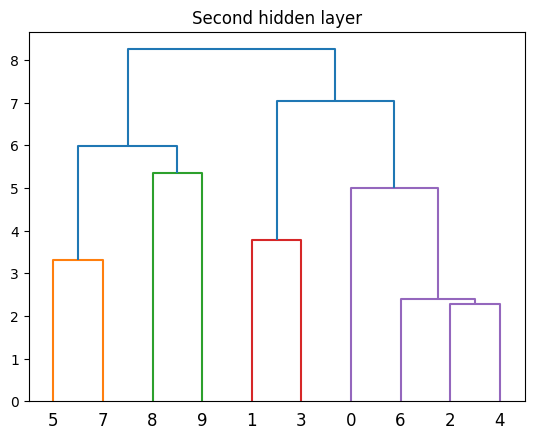

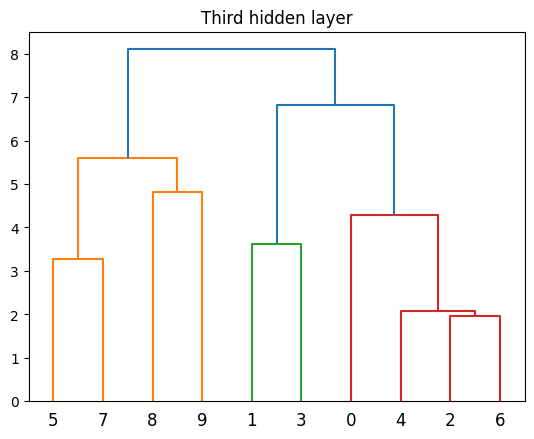

In [ ]:
np.nan_to_num(mean_hidd_repr_matrix_2, copy=False)
np.nan_to_num(mean_hidd_repr_matrix_3, copy=False)

plot_dendrogram(mean_hidd_repr_matrix_2, 'Second hidden layer')
plot_dendrogram(mean_hidd_repr_matrix_3, 'Third hidden layer')

# Linear read-out
The next step of our analysis is to decode representations with a linear read-out (also can be done at each level of the DBN). In other words, we can assess how much information is contained in each hidden representation. This can be done by using the representations to classify the original images with a simple linear classifier

In [ ]:
class LinearModel(torch.nn.Module):
  def __init__(self, layer_size):
    super().__init__()
    self.linear = torch.nn.Linear(layer_size, 10)

  def forward(self, x):
    return self.linear(x)

In [ ]:
# Linear model for each layer of the DBN
layer_size = dbn_fsh.rbm_layers[0].W.shape[1]
linear1 = LinearModel(layer_size).to(device)

layer_size = dbn_fsh.rbm_layers[1].W.shape[1]
linear2 = LinearModel(layer_size).to(device)

layer_size = dbn_fsh.rbm_layers[2].W.shape[1]
linear3 = LinearModel(layer_size).to(device)

Training linear classifiers on the hidden represenations from each layer using the actual labels of the dataset as targets:

In [ ]:
def train_supervised(network, input_data, epochs=1500):
  optimizer = torch.optim.SGD(network.parameters(), lr=0.05)
  loss_fn = torch.nn.CrossEntropyLoss()

  for epoch in range(epochs):
    optimizer.zero_grad()
    predictions = network(input_data).squeeze()
    targets = fsh_mnist_train.targets.reshape(predictions.shape[0])
    loss = loss_fn(predictions, targets)
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
      print('epoch: {:3d}/{}, loss = {:.4f}'.format(epoch+1, epochs, loss))

In [ ]:
train_supervised(linear1, hidden_repr_1)

epoch:   1/1500, loss = 2.2974
epoch: 101/1500, loss = 0.8463
epoch: 201/1500, loss = 0.6857
epoch: 301/1500, loss = 0.6186
epoch: 401/1500, loss = 0.5786
epoch: 501/1500, loss = 0.5511
epoch: 601/1500, loss = 0.5304
epoch: 701/1500, loss = 0.5142
epoch: 801/1500, loss = 0.5010
epoch: 901/1500, loss = 0.4900
epoch: 1001/1500, loss = 0.4806
epoch: 1101/1500, loss = 0.4725
epoch: 1201/1500, loss = 0.4654
epoch: 1301/1500, loss = 0.4591
epoch: 1401/1500, loss = 0.4535


In [ ]:
train_supervised(linear2, hidden_repr_2)

epoch:   1/1500, loss = 2.3429
epoch: 101/1500, loss = 0.7572
epoch: 201/1500, loss = 0.6312
epoch: 301/1500, loss = 0.5760
epoch: 401/1500, loss = 0.5425
epoch: 501/1500, loss = 0.5192
epoch: 601/1500, loss = 0.5019
epoch: 701/1500, loss = 0.4884
epoch: 801/1500, loss = 0.4774
epoch: 901/1500, loss = 0.4683
epoch: 1001/1500, loss = 0.4606
epoch: 1101/1500, loss = 0.4540
epoch: 1201/1500, loss = 0.4482
epoch: 1301/1500, loss = 0.4430
epoch: 1401/1500, loss = 0.4385


In [ ]:
train_supervised(linear3, hidden_repr_3)

epoch:   1/1500, loss = 2.2513
epoch: 101/1500, loss = 0.7845
epoch: 201/1500, loss = 0.6431
epoch: 301/1500, loss = 0.5839
epoch: 401/1500, loss = 0.5488
epoch: 501/1500, loss = 0.5248
epoch: 601/1500, loss = 0.5070
epoch: 701/1500, loss = 0.4931
epoch: 801/1500, loss = 0.4819
epoch: 901/1500, loss = 0.4726
epoch: 1001/1500, loss = 0.4647
epoch: 1101/1500, loss = 0.4579
epoch: 1201/1500, loss = 0.4520
epoch: 1301/1500, loss = 0.4468
epoch: 1401/1500, loss = 0.4421


Evaluating trained linear read-outs with the test set we didn't use before:

In [ ]:
hidden_repr_1_test = get_kth_layer_repr(fsh_mnist_test.data, 0, device)
hidden_repr_2_test = get_kth_layer_repr(hidden_repr_1_test, 1, device)
hidden_repr_3_test = get_kth_layer_repr(hidden_repr_2_test, 2, device)

In [ ]:
predictions_test1 = linear1(hidden_repr_1_test)
predictions_test2 = linear2(hidden_repr_2_test)
predictions_test3 = linear3(hidden_repr_3_test)

In [ ]:
def compute_accuracy(predictions_test, targets):
  predictions_inx = predictions_test.max(axis=1).indices
  accuracy = (predictions_inx == targets).sum() / len(targets)
  return accuracy.item()

In [ ]:
# Computing the accuracy scores for each layer
compute_accuracy(predictions_test1, fsh_mnist_test.targets)

0.8348999619483948

In [ ]:
compute_accuracy(predictions_test2, fsh_mnist_test.targets)

0.8385999798774719

In [ ]:
compute_accuracy(predictions_test3, fsh_mnist_test.targets)

0.8364999890327454

As we can see, the accuracy is almost the same for each of the layer

# Feed-Forward Model
Now we will train a simple feed-forward neural network with the same acrhitecture as the DBN, so we can compare their performances.

Non-linear model that is trained end-to-end to solve a classification task vs a simple linear classifier with the same task using representations of input data learned in an unsupervised way

In [ ]:
class FeedForward(torch.nn.Module):
  def __init__(self, first_hidden_layer_size, second_hidden_layer_size, third_hidden_layer_size):
    super().__init__()
    self.first_hidden = torch.nn.Linear(784, first_hidden_layer_size)
    self.second_hidden = torch.nn.Linear(first_hidden_layer_size, second_hidden_layer_size)
    self.third_hidden = torch.nn.Linear(second_hidden_layer_size, third_hidden_layer_size)
    self.output = torch.nn.Linear(third_hidden_layer_size, 10)

  def forward(self, input):
    relu = torch.nn.ReLU()
    first_hidden_repr = relu(self.first_hidden(input))
    second_hidden_repr = relu(self.second_hidden(first_hidden_repr))
    third_hidden_repr = relu(self.third_hidden(second_hidden_repr))
    output = self.output(third_hidden_repr)
    return output

In [ ]:
ffnn = FeedForward(400, 600, 800).to(device)

In [ ]:
train_supervised(ffnn, fsh_mnist_train.data.reshape((60000, 784)))

epoch:   1/1500, loss = 2.3019
epoch: 101/1500, loss = 1.4370
epoch: 201/1500, loss = 0.9481
epoch: 301/1500, loss = 0.7741
epoch: 401/1500, loss = 0.6868
epoch: 501/1500, loss = 0.6250
epoch: 601/1500, loss = 0.5889
epoch: 701/1500, loss = 0.5457
epoch: 801/1500, loss = 0.5352
epoch: 901/1500, loss = 0.4987
epoch: 1001/1500, loss = 0.4874
epoch: 1101/1500, loss = 0.4702
epoch: 1201/1500, loss = 0.4592
epoch: 1301/1500, loss = 0.4469
epoch: 1401/1500, loss = 0.4395


In [ ]:
predictions_ffnn = ffnn(fsh_mnist_test.data.reshape((10000, 784)))

In [ ]:
compute_accuracy(predictions_ffnn, fsh_mnist_test.targets)

0.8305999636650085

The accuracy is almost the same for both models

In [ ]:
# Confusion matrix for the ffnn model
def plot_conf_matrix(ffnn_model, data, targets):
  predictions = ffnn_model(data.reshape((10000, 784)))
  predictions = predictions.max(axis=1).indices

  conf_mat = confusion_matrix(
      targets.cpu().numpy(),
      predictions.cpu().detach().numpy(),
      labels = np.unique(targets.cpu().numpy()),
      normalize = 'true'
  )

  _, ax = plt.subplots(figsize=(8, 8))
  sns.heatmap(
      conf_mat,
      annot = True,
      fmt = '.2f',
      xticklabels=np.unique(targets.cpu().numpy()),
      yticklabels=np.unique(targets.cpu().numpy())
  )
  plt.xlabel('Predicted', fontsize = 18)
  plt.ylabel('Actual', fontsize = 18)
  plt.title(f'Feed Forward Neural Network', fontsize = 18)

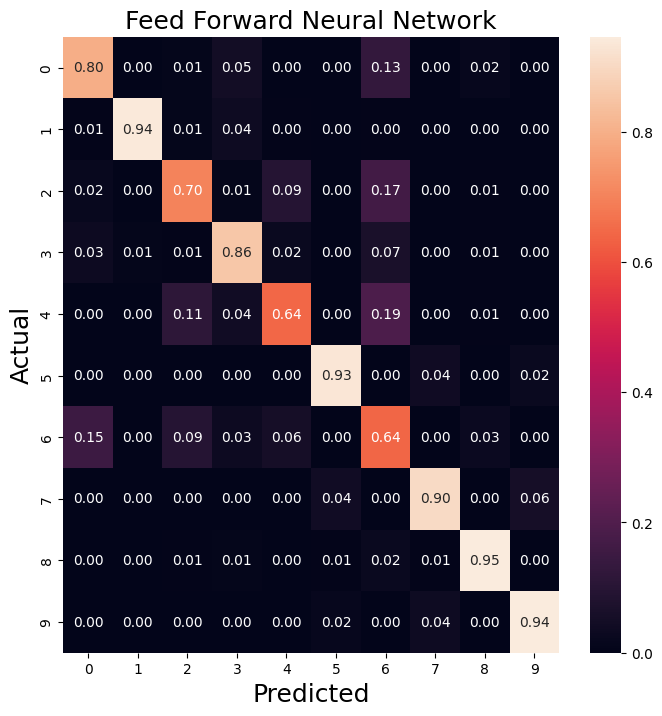

In [ ]:
plot_conf_matrix(ffnn, fsh_mnist_test.data, fsh_mnist_test.targets)

Confusion matrix helps us to analise where exactly the model makes mistakes. In this case, we can see that our model has harder time to recognise categories 6 and 4 (and it actually confuses them with each other often). And if we look up what labels that is we will see that 4 - Coat and 6 - Shirt, so it gives us a bit more perspective to understand that some categories are harder to distinguish. And confusion matrix reflects it.

#Robustness to noise
Injecting some noise in the input data will help as understand how much representations learned by the models are robust to perturbations in the sensory data

We will also plot a psychometric curve to see the changes in the classification accuracy with respect to different noise levels

In [ ]:
def inject_noise(data, noise_level):
  random_gaussian_tensor = torch.randn(data.shape, device = device) * noise_level
  return data + random_gaussian_tensor

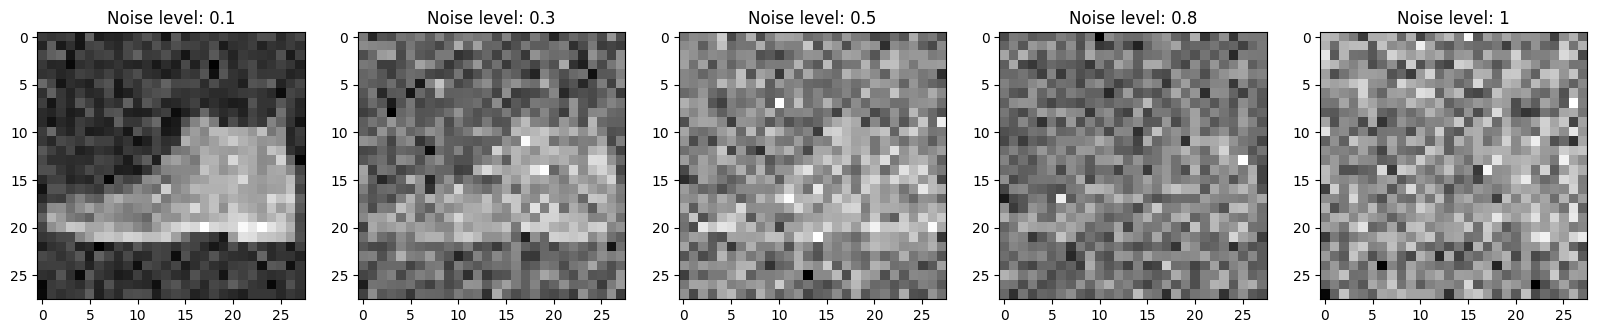

In [ ]:
noise_level = [0.1, 0.3, 0.5, 0.8, 1]
data_noisy = []
fig, axes = plt.subplots (1, 5, figsize = (20, 20))
for i in range(len(noise_level)):
  data_noisy.append(inject_noise(fsh_mnist_test.data, noise_level[i]))
  axes[i].imshow(data_noisy[i][0].reshape(28, 28).to('cpu'), cmap='gray')
  axes[i].set_title('Noise level: {}'.format(noise_level[i]))


The hidden representations for the noisy images are computed using the DBN.

In [ ]:
def acc_noisy(noise_level):
  data_noisy = inject_noise(fsh_mnist_test.data, noise_level)

  hidd_repr_1_noisy = get_kth_layer_repr(data_noisy, 0, device)
  hidd_repr_2_noisy = get_kth_layer_repr(hidd_repr_1_noisy, 1, device)
  hidd_repr_3_noisy = get_kth_layer_repr(hidd_repr_2_noisy, 2, device)

  predictions_1_hidd_noisy = linear1(hidd_repr_1_noisy)
  predictions_2_hidd_noisy = linear2(hidd_repr_2_noisy)
  predictions_3_hidd_noisy = linear3(hidd_repr_3_noisy)

  acc_1_hidd = compute_accuracy(predictions_1_hidd_noisy, fsh_mnist_test.targets)
  acc_2_hidd = compute_accuracy(predictions_2_hidd_noisy, fsh_mnist_test.targets)
  acc_3_hidd = compute_accuracy(predictions_3_hidd_noisy, fsh_mnist_test.targets)

  predictions_ffnn_noisy = ffnn(data_noisy.reshape((10000, 784)))
  acc_ffnn = compute_accuracy(predictions_ffnn_noisy, fsh_mnist_test.targets)

  return acc_1_hidd, acc_2_hidd, acc_3_hidd, acc_ffnn

In [ ]:
acc = acc_noisy(0.3);
print('Accuracy of H1 read-out: %.3f' % acc[0])
print('Accuracy of H2 read-out: %.3f' % acc[1])
print('Accuracy of H3 read-out: %.3f' % acc[2])
print('Accuracy of FF network : %.3f' % acc[3])


Accuracy of H1 read-out: 0.806
Accuracy of H2 read-out: 0.821
Accuracy of H3 read-out: 0.823
Accuracy of FF network : 0.795


Feed-forward networks has a little bit lower accuracy with the noisy data then DBN

Now let's see how the accuracy changes with changes in the noise level:

In [ ]:
for i in noise_level:
  print(f'For the noise level = {i}:')
  acc = acc_noisy(i)
  print('Accuracy of H1 read-out: %.3f' % acc[0])
  print('Accuracy of H2 read-out: %.3f' % acc[1])
  print('Accuracy of H3 read-out: %.3f' % acc[2])
  print('Accuracy of FF network : %.3f' % acc[3])
  print('____________')




For the noise level = 0.1:
Accuracy of H1 read-out: 0.832
Accuracy of H2 read-out: 0.837
Accuracy of H3 read-out: 0.835
Accuracy of FF network : 0.828
____________
For the noise level = 0.3:
Accuracy of H1 read-out: 0.810
Accuracy of H2 read-out: 0.820
Accuracy of H3 read-out: 0.819
Accuracy of FF network : 0.794
____________
For the noise level = 0.5:
Accuracy of H1 read-out: 0.765
Accuracy of H2 read-out: 0.791
Accuracy of H3 read-out: 0.791
Accuracy of FF network : 0.728
____________
For the noise level = 0.8:
Accuracy of H1 read-out: 0.680
Accuracy of H2 read-out: 0.709
Accuracy of H3 read-out: 0.720
Accuracy of FF network : 0.623
____________
For the noise level = 1:
Accuracy of H1 read-out: 0.617
Accuracy of H2 read-out: 0.633
Accuracy of H3 read-out: 0.664
Accuracy of FF network : 0.546
____________


Unsurprisingly, the higher the noise level, the lower the accuracy of the models

Creating the psychometric curves for the Feed-forward network and the DBN (at different levels of internal representations):

In [ ]:
def noise_rob_curves(noise_levels):
  acc_1_hidd = []
  acc_2_hidd = []
  acc_3_hidd = []
  acc_ffnn = []

  for noise_level in noise_levels:
    acc = acc_noisy(noise_level)
    acc_1_hidd.append(acc[0])
    acc_2_hidd.append(acc[1])
    acc_3_hidd.append(acc[2])
    acc_ffnn.append(acc[3])

  fig, ax = plt.subplots(figsize=(6,4))
  ax.plot(range(len(noise_levels)), acc_1_hidd)
  ax.plot(range(len(noise_levels)), acc_2_hidd)
  ax.plot(range(len(noise_levels)), acc_3_hidd)
  ax.plot(range(len(noise_levels)), acc_ffnn)

  ax.set_title('Robustness to noise')
  ax.set_xlabel('Noise level (%)')
  ax.set_ylabel('Accuracy')
  ax.grid()
  plt.xticks(range(len(noise_levels)), [int(l*100) for l in noise_levels])
  plt.legend(['First hidden', 'Second hidden', 'Third hidden', 'FFNN'])

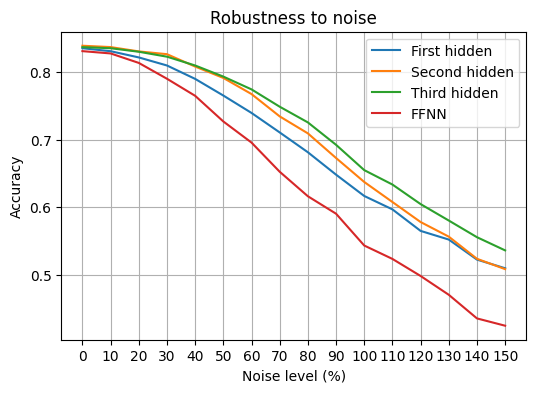

In [ ]:
noise_levels = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1, 1.1, 1.2, 1.3, 1.4, 1.5]
noise_rob_curves(noise_levels)

# Perturbing the models with adversarial attacks

In case of adversarial attack the input is modified so the model cannot classify it correctly anymore. So the loss for that specific input has to increase

When we are training the model, we change the weights based on the value of the gradient of the loss function, using the opposite direction with respect to the gradient (because we want the loss to decrease)

That means that, in order to create an adersarial sample, we change the following:
1. Modify the input, not the weights
2. We go in the same direction as the gradient (because we want the loss to increase)

In [ ]:
def fgsm_attack(image, epsilon, data_grad):
  sign_data_grad = data_grad.sign()

  perturbed_image = image + epsilon*sign_data_grad

  perturbed_image = torch.clamp(perturbed_image, 0, 1)

  return perturbed_image

In [ ]:
class DBNWithReadOut(torch.nn.Module):
  def __init__(self, dbn_fsh, readouts, readout_level=0):
    super().__init__()
    self.readouts = readouts
    self.dbn_fsh = dbn_fsh
    self._require_grad()
    self.readout_level = readout_level

  def _require_grad(self):
    for rbm in self.dbn_fsh.rbm_layers:
      rbm.W.requires_grad_()
      rbm.h_bias.requires_grad_()

  def forward(self, image):
    p_v = image
    hidden_states = []
    for rbm in self.dbn_fsh.rbm_layers:
      p_v = p_v.view((p_v.shape[0], -1))
      p_v, v = rbm(p_v)
      hidden_states.append(p_v)
    return self.readouts[self.readout_level].forward(hidden_states[self.readout_level])


In [ ]:
dbn_readout = DBNWithReadOut(dbn_fsh, [linear1, linear2, linear3], readout_level=2)

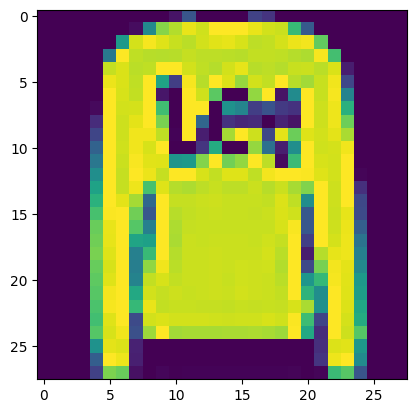

In [ ]:
# Let's see how the adversarial attack looks on the example
test_sample_idx = 1
test_image = fsh_mnist_test.data[test_sample_idx].reshape(1, 784)
__ = plt.imshow(test_image.reshape(28, 28).to('cpu'))

We classify this "clean: image with one of the models previously trained.
And then we will modify the image to attack the network

We can change the model we attack (between ffnn and dbn)

In [ ]:
attacked_model = ffnn

In [ ]:
#attacked_model = dbn_readout

In [ ]:
test_image.requires_grad_()
model_outputs = attacked_model(test_image)
prediction = torch.argmax(model_outputs)
print(f'The prediction of the model for this clean sample is {prediction}')

The prediction of the model for this clean sample is 2


Now we will visualize adversarial sample

Epsilon parameter defines the strenght of the atack (that's discussed later)

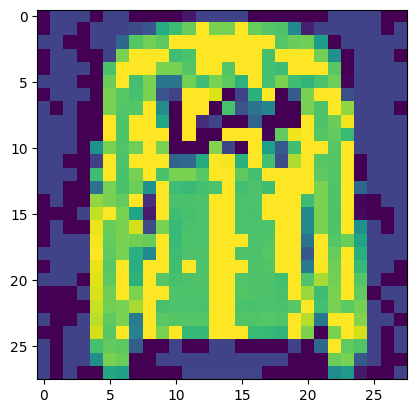

In [ ]:
epsilon = 0.2
test_image_label = fsh_mnist_test.targets[test_sample_idx].unsqueeze(0)
loss_value = torch.nn.functional.cross_entropy(model_outputs, test_image_label)
attacked_model.zero_grad()
loss_value.backward() # computes the grad for activated parameters
image_grad = test_image.grad.data

perturbed_image = fgsm_attack(test_image, epsilon, image_grad)
perturbed_image_np = perturbed_image.detach().to('cpu').numpy()
__ = plt.imshow(perturbed_image_np.reshape(28, 28))

In [ ]:
model_outputs = attacked_model(perturbed_image.view((perturbed_image.shape[0], -1)))
print(f'The prediction of the model for the perturbed sample is {torch.argmax(model_outputs)}')

The prediction of the model for the perturbed sample is 6


# Resisting to adversarial attack
Comparing the models' ability to resist the attacks.

DBN can also reduce the impact of the attack with one "top-down" reconstruction step, from the hidden representation of the last layer to the visible units, and back to the hidden representation



In [ ]:
def test_robustness_to_attack(model, device, test_loader, epsilon, num_steps=0, verbose=True):
  correct = 0
  print_reconstruction = num_steps > 0

  for data, target in tqdm.tqdm(test_loader):
    data, target = data.to(device), target.to(device)
    data = data.reshape(-1, 784)
    data.requires_grad = True

    output = model.forward(data)

    init_pred = torch.argmax(output)

    if init_pred.item() != target.item():
      continue

    if (print_reconstruction and verbose):
      print("\nHere's the original sample:\n")
      plt.imshow(data[0].detach().to('cpu').numpy().reshape(28,28))
      plt.show()

    loss = torch.nn.functional.nll_loss(output, target)
    model.zero_grad()
    loss.backward()
    data_grad = data.grad.data  # collect the gradient with respect to the input data
    perturbed_data = fgsm_attack(data, epsilon, data_grad)

    if (print_reconstruction and verbose):
        print("\nHere's a perturbed sample:\n")
        plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
        plt.show()


    if num_steps > 0:
          for __ in range(0, num_steps):
              perturbed_data, __ = model.dbn_fsh.reconstruct(perturbed_data)
          if (print_reconstruction and verbose):
              print(f"\nHere's what a {num_steps}-steps reconstructed sample looks like:\n")
              plt.imshow(perturbed_data[0].detach().to('cpu').numpy().reshape(28,28))
              plt.show()
              print_reconstruction = False

        # Re-classify the perturbed image
    output = model(perturbed_data)

        # Check for success
        # get the index of the max element in the output
    final_pred = output.max(1, keepdim=True)[1]
    final_pred = output.argmax(-1)
    correct += (final_pred == target).sum()

    # Calculate final accuracy for this epsilon
  final_acc = correct/float(len(test_loader.sampler))
  print("\nEpsilon: {}\nTest Accuracy: {:.2f}%\n".format(epsilon, final_acc*100))

  return final_acc.item()


In [ ]:
data = [[d, l] for d, l in zip(fsh_mnist_test.data, fsh_mnist_test.targets)]
test_loader = torch.utils.data.DataLoader(
    data,
    shuffle = True,
    batch_size = 1
)

First, we see how the Feed-forward does:

In [ ]:
device = torch.device('cuda')
final_acc = test_robustness_to_attack(ffnn, device,
                                      test_loader, epsilon=0.1,
                                      num_steps=0)

100%|██████████| 10000/10000 [00:16<00:00, 588.25it/s]


Epsilon: 0.1
Test Accuracy: 27.20%



Now, DBN:

In [ ]:
final_acc2 = test_robustness_to_attack(dbn_readout, device,
                                       test_loader, epsilon=0.1,
                                       num_steps=0)

100%|██████████| 10000/10000 [00:30<00:00, 333.05it/s]


Epsilon: 0.1
Test Accuracy: 41.75%



Finally, we will see if one step of top-down reconstruction from the generative model improves the resilence:

  0%|          | 0/10000 [00:00<?, ?it/s]


Here's the original sample:



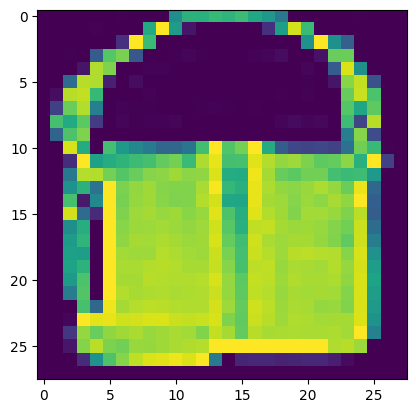


Here's a perturbed sample:



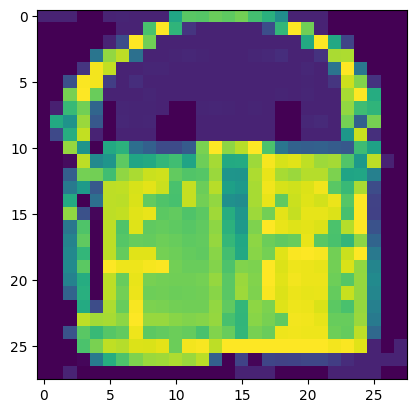


Here's what a 1-steps reconstructed sample looks like:



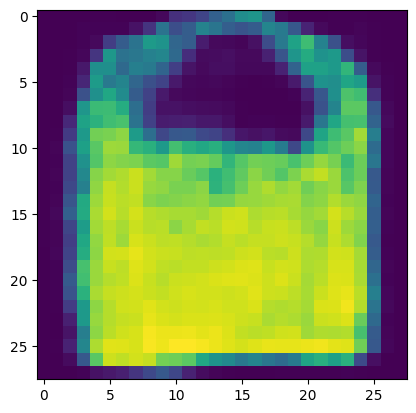

100%|██████████| 10000/10000 [00:50<00:00, 197.08it/s]


Epsilon: 0.1
Test Accuracy: 39.52%



In [ ]:
final_acc3 = test_robustness_to_attack(dbn_readout, device,
                                       test_loader, epsilon=0.1,
                                       num_steps=1)

We can see that our feed-forward performes the worsh in terms of resisting to the adversarial attack. However, DBN's accuracy score is also not high and one step of top-down reconstruction didn't do much to improve it

# Effect of the noise parameter $ϵ$
We will see the robustness of each model to adversarial attacks woth respect to changes in the strengths of the attack



In [ ]:
epsilon_values = [0, 0.05, 0.10, 0.15, 0.20, 0.25]

def test_effect(model, n_steps):
  accuracies = list()

  for eps in epsilon_values:
    acc = test_robustness_to_attack(model, device, test_loader, eps, num_steps=n_steps, verbose=False)
    accuracies.append(acc)

  return accuracies

In [ ]:
%%capture
accuracies_ffnn = test_effect(ffnn, n_steps=0)
accuracies_dbn_0 = test_effect(dbn_readout, n_steps=0)
accuracies_dbn_1 = test_effect(dbn_readout, n_steps=1)

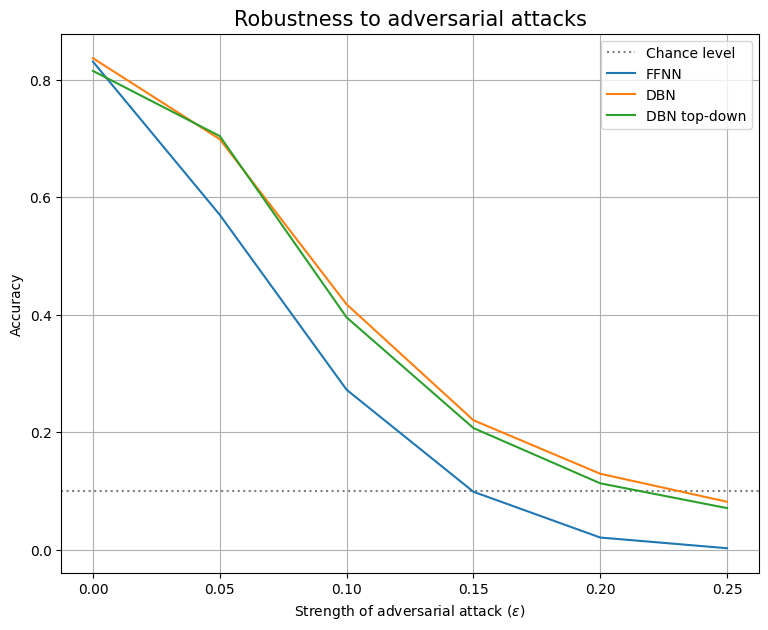

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(9, 7), sharey=True)

__ = ax.axhline(0.1, color='gray', linestyle=':')
__ = ax.plot(epsilon_values, accuracies_ffnn)
__ = ax.plot(epsilon_values, accuracies_dbn_0)
__ = ax.plot(epsilon_values, accuracies_dbn_1)
__ = ax.set_xlabel('Strength of adversarial attack ($\epsilon$)')
__ = ax.set_ylabel('Accuracy')
__ = ax.set_title('Robustness to adversarial attacks', {'fontsize':15})
__ = ax.legend(['Chance level', 'FFNN', 'DBN', 'DBN top-down'])
__ = ax.grid()

The plot proves some of the previous points: Feed-forward network performes worse than the DBN and there is not much of a change with addition of top-down step

And, reasonably, the stronger the attack, the weaker the resilence of the models

# CNN
In addition, I decided to see how will CNN (with simple architecture) perform on our dataset

In [ ]:
from keras import models, layers

model = models.Sequential()
model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(28, 28, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))
model.add(layers.MaxPooling2D((2,2)))
model.add(layers.Conv2D(64, (3,3), activation='relu'))

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10))

model.compile(optimizer='adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
model.summary()

data_train = fsh_mnist_train.data.cpu().numpy()
targets_train = fsh_mnist_train.targets.cpu().numpy()
data_test = fsh_mnist_test.data.cpu().numpy()
targets_test = fsh_mnist_test.targets.cpu().numpy()

history = model.fit(data_train, targets_train, epochs=5,
                    validation_data = (data_test, targets_test))

test_loss, test_acc = model.evaluate(data_test, targets_test, verbose=2)
print(test_acc)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 5, 5, 64)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (None, 3, 3, 64)          36928     
                                                                 
 flatten_1 (Flatten)         (None, 576)              

In [ ]:
predictions = model.predict(data_test)

313/313 [==============================] - 1s 2ms/step


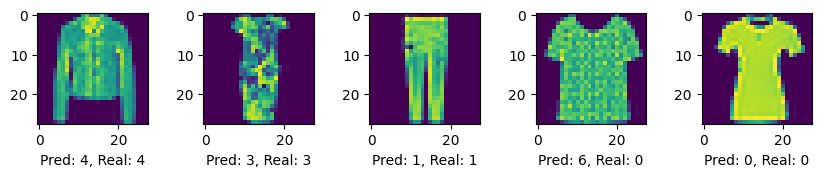

In [ ]:
numbers = [10, 100, 200, 1000, 4001]

fig, axes = plt.subplots(1, len(numbers), figsize = (10, 5))
for num in range(len(numbers)):
  axes[num].imshow(data_test[numbers[num]])
  axes[num].set_xlabel(f'Pred: {np.argmax(predictions[numbers[num]])}, Real: {targets_test[numbers[num]]}')

fig.subplots_adjust(wspace=0.5)


As we can see, CNN performed better than other models and has a quite high accuracy score

# Reference papers


*   [G. Hinton - A Practical Guide to Training Restricted Boltzmann Machines](https://www.cs.toronto.edu/~hinton/absps/guideTR.pdf)

*   [Testolin et al. - Deep unsupervised learning on a desktop PC: a primer for cognitive scientists](https://www.frontiersin.org/articles/10.3389/fpsyg.2013.00251/full)



